In [1]:
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP, AdaptiveSR
from besos.parameters import RangeParameter, expand_plist, wwr
from besos.problem import EPProblem

import pyKriging
from pyKriging.krige import kriging
import numpy as np

import pandas as pd

from typing import Union, List, Tuple

Adaptive Surrogate models require more setup that other parts of BESOS, since they have several optional features, and there are different approaches to using them. Below is the template that can be used to make an adaptive surrogate.

In [2]:
tabular = Union[np.array, pd.DataFrame]
DF = pd.DataFrame

class ExampleTemplate(AdaptiveSR):
    # helper functions provided by AdaptiveSR (Generally avoid editing these, but use them as needed)
    # append_data(X, y)
    # do_infill
    # get_from_reference
    
    # functions with defaults (These can be removed from this template if you like the defaults)
        # They may depend on some of the optional functions in order to work if using the defaults
    # __init__
    # infill (depends on -> get_infill)
    # update_model
    
    # optional functions (These will not work unless you implement them)
    # get_infill
    
    # required functions
    # train
    # eval_single
    
    def __init__(self, custom_argument_1, custom_arg_2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # do stuff with custom arguments here
    
    def get_infill(self, num_datapoints: int) -> tabular:
        """Generates data that is most likely to improve the model, and can be used for retraining.

        :param num_datapoints: the number of datapoints to generate
        :return: the datapoints generated, in some tabular datastructure
        """
        raise NotImplementedError

    def update_model(self, new_data: tabular, old_data: DF = None) -> None:
        """Modifies self.model to incorporate the new data.

        This function should not edit the existing data

        :param new_data: a table of inputs and outputs
        :param old_data: the table of inputs and outputs without the new data
        :return: None
        """
        self.train()
        
    def infill(self, num_datapoints: int) -> None:
        """Adds num_datapoints samples to the model and updates it.

        :param num_datapoints: number of datapoints to add to the model's training set
        :return: None
        """
        inputs: DF = self.problem.to_df(self.get_infill(num_datapoints), 'inputs')
        outputs: DF = self.get_from_reference(inputs)
        self.do_infill(pd.concat([inputs, outputs], axis=1))

    def train(self) -> None:
        """Generates a new model using the stored data, and stores it as self.model"""
        pass

    def eval_single(self, values: List) -> Tuple:
        """Evaluates a single input point

        :param values: The datapoint to evaluate
        :param **kwargs:
        :return: A tuple of the predicted outputs for this datapoint
        """
        pass

Here we will go through piece by piece how to wrap a model from pyKrigging in our setup.

In [3]:
class KrigingEval(AdaptiveSR):
    # The model cannot handle multiple objectives, so we check for this when initializing
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if self.problem.num_outputs != 1:
            raise ValueError('This model cannont handle multiobjective problems.')
        if self.problem.num_constraints != 0:
            raise ValueError('This model cannont handle constrained problems.')
    
    # pyKriging models are able to generate datapoints which will improve the model the most
    # **kwargs is included, since the model's function has some options which we may want to access
    # such as the ability to sample near the minimum, instead of near the point of greatest uncertainty
    def get_infill(self, num_datapoints, **kwargs):
        return self.model.infill(num_datapoints, **kwargs)
    
    # since pyKriging's model has an addPoint method, we will use it to update the model instead
    # of initialising a new one each time. We loop through all of the new datapoints
    # and add them one at a time, then retrain the inner model.
    # note that self.model.train is not the same as self.train
    def update_model(self, new_data, old_data = None) -> None:
        for index, *row in new_data.itertuples():
            inputs = row[:self.problem.num_inputs]
            output = row[-1]
            assert len(row) == self.problem.num_inputs + self.problem.num_outputs
            self.model.addPoint(inputs, output)
        self.model.train()
    
    
    
    # The infill function will work automatically, since we have defined get_infill and update_model
    
    
    # we initialize and store a kriging model on the stored training data, and then
    # run the internal model's train function.
    def train(self):
        self.model = kriging(self.data.values[:,:-1], self.data.values[:,-1])
        self.model.train()
    
    # this model expects a 2d array representing a batch of inputs, but we only want 
    # to evaluate one input point at a time, so we wrap the inputs in a list before passing
    # them to the model
    def eval_single(self, values):
        return ((self.model.predict(list(values)),), ())

In [4]:
building = ef.get_building()

parameters=expand_plist(
    {'Mass NonRes Wall Insulation':
      {'Thickness': (0.05, 0.99)}
    })

parameters.append(wwr())

problem = EPProblem(parameters)

evaluator = EvaluatorEP(problem, building)

inputs = sampling.dist_sampler(sampling.lhs, problem, 10)
inputs = sampling.add_extremes(inputs, problem)
# this helps this specific evaluator auto-detect the min/max correctly

In [5]:
x = sampling.dist_sampler(sampling.lhs, problem, 10)
x

Thickness  Window to Wall Ratio
0   0.219345              0.229035
1   0.059407              0.980293
2   0.740063              0.384315
3   0.419925              0.794032
4   0.447114              0.182311
5   0.954683              0.777211
6   0.587338              0.565754
7   0.245316              0.691599
8   0.658982              0.073718
9   0.877877              0.488757

In [6]:
sampling.add_extremes(x, problem)

Thickness  Window to Wall Ratio
0    0.219345              0.229035
1    0.059407              0.980293
2    0.740063              0.384315
3    0.419925              0.794032
4    0.447114              0.182311
5    0.954683              0.777211
6    0.587338              0.565754
7    0.245316              0.691599
8    0.658982              0.073718
9    0.877877              0.488757
10   0.050000              0.010000
11   0.990000              0.990000

In [7]:
k = KrigingEval(reference=evaluator)

In [8]:
k.do_infill(inputs) # even with cached evaluator results, this will take time for the pyKriging train step

In [9]:
k.model.train()

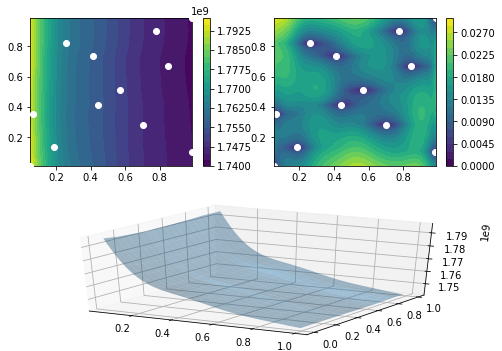

In [10]:
k.model.plot()

In [11]:
k.infill(5) 

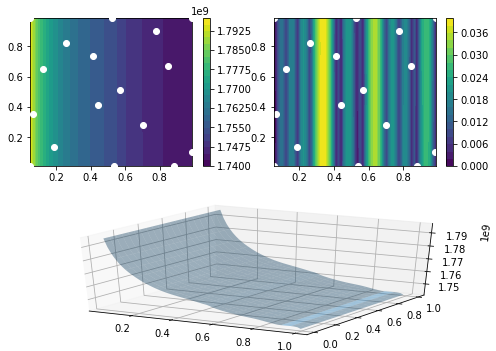

In [12]:
k.model.plot()

In [13]:
k.data

Thickness  Window to Wall Ratio  Electricity:Facility
0    0.066948              0.355337          1.789301e+09
1    0.411755              0.737724          1.756964e+09
2    0.776919              0.899997          1.746002e+09
3    0.260692              0.820995          1.763481e+09
4    0.985271              0.103876          1.742622e+09
5    0.441960              0.413724          1.756074e+09
6    0.186856              0.132202          1.769336e+09
7    0.701429              0.283104          1.747421e+09
8    0.847135              0.668778          1.744146e+09
9    0.568307              0.510337          1.751405e+09
10   0.050000              0.010000          1.795928e+09
11   0.990000              0.990000          1.742036e+09
12   0.050000              0.990000          1.795928e+09
13   0.537750              0.010000          1.753124e+09
14   0.526768              0.990000          1.753343e+09
15   0.881621              0.010000          1.743449e+09
16   0.121992              0.648545          1.777156e+09